<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# _*Qiskit Aqua: Generating Random Variates*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-tutorials.

***
### Contributors
Albert Akhriev<sup>[1]</sup>, Jakub Marecek<sup>[1]</sup>, Stephen Wood<sup>[1]</sup>, Marco Pistoia<sup>[1]</sup>
### Affliation
- <sup>[1]</sup>IBMQ

### Uniformly-distributed scalars and vectors

Functions in the base class \textbf{UnivariateDistribution}

```python
def uniform_rand_float64(self, size: int, vmin: float, vmax: float) -> np.ndarray:
    """
    Generates a vector of random float64 values in the range [vmin, vmax].
    :param size: length of the vector.
    :param vmin: lower bound.
    :param vmax: upper bound.
    :return: vector of random values.
    """
    assert sys.maxsize == np.iinfo(np.int64).max                                # sizeof(int) == 64 bits
    assert isinstance(size, int) and size > 0
    assert isinstance(vmin, float) and isinstance(vmax, float) and vmin <= vmax
    nbits = 7 * 8                                                               # nbits > mantissa of float64
    bit_str_len = (nbits * size + self.num_target_qubits - 1) // self.num_target_qubits
    job = execute(self.circuit, self.backend, shots=bit_str_len, memory=True)
    bit_str = ''.join(job.result().get_memory())
    scale = float(vmax - vmin) / float(2**nbits - 1)
    return np.array([vmin + scale * float(int(bit_str[i:i+nbits], 2))
                     for i in range(0, nbits * size, nbits)], dtype=np.float64)
```

```python
def uniform_rand_int64(self, size: int, vmin: int, vmax: int) -> np.ndarray:
    """
    Generates a vector of random int64 values in the range [vmin, vmax].
    :param size: length of the vector.
    :param vmin: lower bound.
    :param vmax: upper bound.
    :return: vector of random values.
    """
    assert sys.maxsize == np.iinfo(np.int64).max                                # sizeof(int) == 64 bits
    assert isinstance(size, int) and size > 0
    assert isinstance(vmin, int) and isinstance(vmax, int) and vmin <= vmax
    assert abs(vmin) <= 2**52 and abs(vmax) <= 2**52                            # 52 == mantissa of float64
    return np.rint(self.uniform_rand_float64(size, float(vmin), float(vmax))).astype(np.int64)
```

Function in the base class \textbf{NormalDistribution}

```python
def normal_rand_float64(self, size: int) -> np.ndarray:
    """
    Draws a sample vector from standard normal distribution (mu=0, std=1)
    using Box-Muller method.
    """
    EPS = np.sqrt(np.finfo(np.float64).tiny)
    assert isinstance(size, int) and size > 0
    rand_vec = np.zeros((size,), dtype=np.float64)

    # Generate array of uniformly distributed samples.
    n = 2 * size
    x = np.reshape(self.uniform_rand_float64(n, float(0.0), float(1.0)), (-1, 2))

    x1 = 0.0                # first sample in a pair
    c = 0                   # counter
    for d in range(size):
        r2 = 2.0
        while r2 >= 1.0 or r2 < EPS:
            # Regenerate array of uniformly distributed samples upon shortage.
            if c > n:
                c = 0
                n = max(((size // 10) // 2) * 2, 2)
                x = np.reshape(self.uniform_rand_float64(n, float(0.0), float(1.0)), (-1, 2))

            x1 = 2.0 * x[c, 0] - 1.0        # first sample in a pair
            x2 = 2.0 * x[c, 1] - 1.0        # second sample in a pair
            r2 = x1 * x1 + x2 * x2
            c += 1

        f = np.sqrt(np.abs(-2.0 * np.log(r2) / r2))
        rand_vec[d] = f * x1
    return rand_vec
```

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys, math, time
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from qiskit import BasicAer
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua.components.random_distributions import MultivariateNormalDistribution
from qiskit.aqua.components.uncertainty_problems import FixedIncomeExpectedValue
from qiskit.aqua.components.random_distributions import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.tools.visualization import plot_histogram, circuit_drawer

# In this example we use 'qasm_simulator' backend.
glo_backend = BasicAer.get_backend("qasm_simulator")

# Parameters.
glo_num_qubits = 5

#### Uniform distribution of floating point numbers.

Uniform distribution of floating point numbers:
sample type: <class 'numpy.ndarray'> , element type: float64 , shape: (54321,)
sample min: -7.6697, max: 19.5199
time: creation: 0.00043, sampling: 6.49


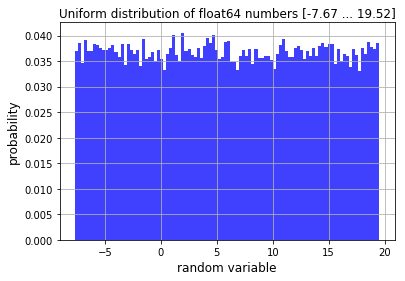

In [8]:
# Create uniform distribution sampler.
start_time = time.time()
uniform = UniformDistribution(glo_num_qubits, backend=glo_backend)
creation_time = time.time() - start_time

# Draw a sample.
start_time = time.time()
sample = uniform.uniform_rand_float64(size=54321, vmin=-7.67, vmax=19.52)
sampling_time = time.time() - start_time

# Print out some details.
print("Uniform distribution of floating point numbers:")
print("sample type:", type(sample), ", element type:", sample.dtype, ", shape:", sample.shape)
print("sample min: {:.4f}, max: {:.4f}".format(np.amin(sample), np.amax(sample)))
print("time: creation: {:.5f}, sampling: {:.2f}".format(creation_time, sampling_time))

# Plotting the distribution.
plt.hist(sample.ravel(),
         bins=min(int(np.ceil(np.sqrt(sample.size))), 100),
         density=True, facecolor='b', alpha=0.75)
plt.xlabel("random variable", size=12)
plt.ylabel("probability", size=12)
plt.title("Uniform distribution of float64 numbers [{:.2f} ... {:.2f}]".format(
            np.amin(sample), np.amax(sample)), size=12)
plt.grid(True)
# plt.savefig("uniform_distrib_float.png", bbox_inches="tight")
plt.show()

#### Uniform distribution of integer numbers.

Uniform distribution of integer numbers:
sample type: <class 'numpy.ndarray'> , element type: int64 , shape: (54321,)
sample min: 37, max: 841
time: sampling: 6.36


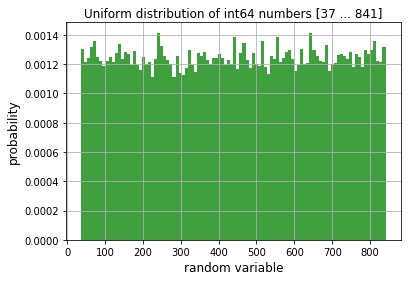

In [9]:
# Draw a sample, reuse the previous instance of the sampler.
start_time = time.time()
sample = uniform.uniform_rand_int64(size=54321, vmin=37, vmax=841)
sampling_time = time.time() - start_time

# Print out some details.
print("Uniform distribution of integer numbers:")
print("sample type:", type(sample), ", element type:", sample.dtype, ", shape:", sample.shape)
print("sample min: {:d}, max: {:d}".format(np.amin(sample), np.amax(sample)))
print("time: sampling: {:.2f}".format(sampling_time))

# Plotting the distribution.
plt.hist(sample.ravel(),
         bins=min(int(np.ceil(np.sqrt(sample.size))), 100),
         density=True, facecolor='g', alpha=0.75)
plt.xlabel("random variable", size=12)
plt.ylabel("probability", size=12)
plt.title("Uniform distribution of int64 numbers [{:d} ... {:d}]".format(
            np.amin(sample), np.amax(sample)), size=12)
plt.grid(True)
# plt.savefig("uniform_distrib_int.png", bbox_inches="tight")
plt.show()

#### Normal distribution

Normal distribution (mu=2.400, sigma=5.100):
sample type: <class 'numpy.ndarray'> , element type: float64 , shape: (4321,)
sample min: -14.4205, max: 20.7960
time: creation: 0.01026, sampling: 1.60


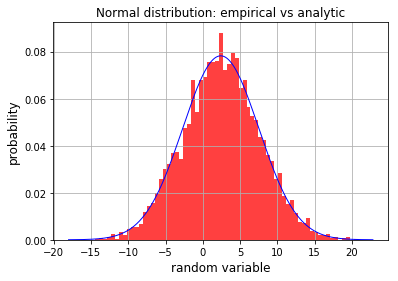

In [10]:
# Create normal distribution sampler.
mu = 2.4
sigma = 5.1
start_time = time.time()
normal = NormalDistribution(glo_num_qubits, mu=mu, sigma=sigma, backend=glo_backend)
creation_time = time.time() - start_time

# Draw a sample from the normal distribution.
start_time = time.time()
sample = normal.normal_rand_float64(size=4321)
sampling_time = time.time() - start_time

# Print out some details.
print("Normal distribution (mu={:.3f}, sigma={:.3f}):".format(mu, sigma))
print("sample type:", type(sample), ", element type:", sample.dtype, ", shape:", sample.shape)
print("sample min: {:.4f}, max: {:.4f}".format(np.amin(sample), np.amax(sample)))
print("time: creation: {:.5f}, sampling: {:.2f}".format(creation_time, sampling_time))

# Plotting the distribution.
x = np.linspace(mu - 4.0 * sigma, mu + 4.0 * sigma, 1000)
analyt = np.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * math.sqrt(2.0 * math.pi))
plt.hist(sample.ravel(),
         bins=min(int(np.ceil(np.sqrt(sample.size))), 100),
         density=True, facecolor='r', alpha=0.75)
plt.plot(x, analyt, '-b', lw=1)
plt.xlabel("random variable", size=12)
plt.ylabel("probability", size=12)
plt.title("Normal distribution: empirical vs analytic", size=12)
plt.grid(True)
# plt.savefig("normal_distrib.png", bbox_inches="tight")
plt.show()